In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

# Analisis exploratorio puntos de venta (pos.csv)
En esta sección vamos a estar realizando el preprocesamiento de los datos de pos, quitando errores y reemplazando valores faltantes. 
El archivo pos.csv contiene la información de todos los puntos de venta.

Tenemos muchas columnas que podemos utilizar para realizar algún tipo de clasificación. Tengamos en cuenta que en el apartado anterior, nos dimos cuenta que muchos puntos de venta solo tienen 1 venta. 
Podríamos intentar encontrar puntos de ventas semejantes, con algún algoritmo de clustering, y agregar estas predicciones como características a nuestro modelo. 

De todas formas, el algoritmo que utilizamos en el apartado de predicción
trabaja con valores númericos, es decir, si mezclamos los valores de pos.csv con ventas directamente, quizás encontremos algún tipo de relación. De todas formas, debemos proceder a la limpieza de los datos de este dataset.


In [2]:
df_pos = pd.read_csv('./data/pos.csv')
df_pos.describe(include='all')

id_pos  competidores  ingreso_mediana  ingreso_promedio  \
count           13265  13228.000000     13255.000000      13255.000000   
unique          12934           NaN              NaN               NaN   
top     Not Available           NaN              NaN               NaN   
freq              187           NaN              NaN               NaN   
mean              NaN     26.942093     55246.302913      72583.559634   
std               NaN     48.640683     14956.105565      19058.394087   
min               NaN      0.000000     15519.520000      22629.590000   
25%               NaN      4.000000     45749.675000      60149.599335   
50%               NaN     14.000000     53975.180000      70706.733330   
75%               NaN     32.000000     62144.407835      81347.835665   
max               NaN   2607.000000    165644.920000     201504.010000   

        densidad_poblacional       pct_0a5       pct_5a9     pct_10a14  \
count           13254.000000  13256.000000  13254.000000  13254.000000   
unique                   NaN           NaN           NaN           NaN   
top                      NaN           NaN           NaN           NaN   
freq                     NaN           NaN           NaN           NaN   
mean            11560.079662      6.028763      6.111135      6.054291   
std             16075.949863      1.241332      1.185604      1.183307   
min                 0.050000      0.000000      0.000000      0.000000   
25%              4569.852273      5.410000      5.520000      5.480000   
50%              8497.115000      5.991682      6.099167      6.064583   
75%             12858.229583      6.595875      6.696667      6.692000   
max            278007.800000     21.890000     20.380000     15.280000   

           pct_15a19     pct_20a24     pct_25a29     pct_30a34     pct_35a39  \
count   13256.000000  13254.000000  13254.000000  13254.000000  13254.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        6.442756      7.753941      7.173834      6.839581      5.939916   
std         1.844200      3.821274      2.015550      1.450926      0.925992   
min         0.120000      0.270000      0.320000      0.350000      0.340000   
25%         5.653333      6.020000      6.042875      6.070000      5.480000   
50%         6.209444      7.014000      7.012111      6.780000      5.942500   
75%         6.852050      8.320706      7.991250      7.490000      6.394821   
max        41.550000     73.540000     26.740000     18.480000     16.660000   

           pct_40a44     pct_45a49     pct_50a54     pct_55a59     pct_60a64  \
count   13254.000000  13254.000000  13254.000000  13254.000000  13254.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        6.284095      6.325390      6.930998      6.692093      5.800067   
std         0.861561      0.909160      1.020568      1.088922      1.185471   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         5.880000      5.901123      6.473534      6.173333      5.226000   
50%         6.312000      6.326491      6.931042      6.667750      5.714000   
75%         6.730000      6.764000      7.432500      7.218095      6.281667   
max        14.980000     13.870000     14.243333     13.840000     17.360000   

           pct_65a69     pct_70a74     pct_75a79     pct_80a84    pct_85ainf  \
count   13254.000000  13254.000000  13254.000000  13254.000000  13254.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           Na

### Analisis de id_pos
Sabemos de antemano, que id_pos tiene que ser de tipo númerico. Verificamos si tienen valores faltantes o valores erroneos.

In [3]:
# valores únicos antes de las pruebas
len(df_pos.id_pos.unique())

12935

In [4]:
# verificamos si tiene valores null
df_pos.id_pos.isna().any()

True

Intentamos transformar toda la columna a valores númericos, los valores no parseables los mantiene como nan.

In [5]:
df_pos.id_pos = pd.to_numeric(df_pos.id_pos, errors="coerce")

Removemos todos los items que poseen id_pos vacíos o tienen valores negativos. No los imputamos porque no tiene sentido inventar valores de id_pos. Tenemos 12897 puntos de venta distintos.

In [6]:
index_to_drop = df_pos[(df_pos.id_pos.isna()) | (df_pos.id_pos<0)].index
df_pos = df_pos.drop(index=index_to_drop)

In [7]:
# valores únicos antes de las pruebas
len(df_pos.id_pos.unique())

12897

___

## Valores faltantes/nulos
Buscamos puntos de ventas que tienen todos los datos faltantes, existen 46 rows con id_pos correcto, pero que todos sus datos están vacíos. 

In [8]:
# buscamos las filas que tienen todas las columnas como valores faltantes
ix_all_nan = (
    df_pos
    .set_index('id_pos')
    .isna()
    .all(axis=1)
)

#nos quedamos solamente con las que tienen todas las columnas en null. 
ix_all_nan = ix_all_nan[lambda df: df==True]

ix_all_nan.shape, df_pos.shape

((46,), (12897, 33))

In [9]:
ix_all_nan = pd.DataFrame(ix_all_nan.index)
ix_all_nan.head()

id_pos
0    288.0
1  27400.0
2  31250.0
3  37897.0
4  38933.0

En el dataframe ix_all_nan se encuentra todos los valores de id_pos que tienen todas las demás columnas con valores faltantes.   
En el dataframe df_pos se encuentran todos los posibles puntos de ventas. 

¿Podríamos descartar las 46 muestras?, si fuera por importancia, frente a un total de 12897 no restaría demasiado datos. 
Tenemos otras situaciones en las que esas 46 muestras deberían quedarse: si se encuentran en el archivo de salida de ejemplo y si existen ventas asociadas a ellos. 


La competición daba como posible respuesta el archivo "ejemploRespuesta.csv", en él se deberían encontrar todas las posibles respuestas de POS correctas, con los que los jurados harían las pruebas pertinentes. 
El enunciado dice: 

>Como en todas las competencias, cada solución propuesta es evaluada en contraposición a las respuestas correctas. El conjunto de respuestas se divide en dos, de manera secreta y al azar. Durante la competencia se mostrará el puntaje correspondiente a una mitad de puntos de venta posibles. Al finalizar la competencia, el puntaje válido será el correspondiente a la otra mitad de puntos de venta. ¡A no sobreajustar!

Por esta parte, asumimos que id de POS correctos son los que se encuentran en el archivo de ejemploRespuestas.csv.

>Los id_pos (primer columna) deben coincidir con los id_pos del archivo Ejemplo de Respuesta, en caso contrario la plataforma devolverá un error


Por lo tanto, vamos a comprobar que los elementos que poseemos en df_pos son todos los que están en "ejemploRespuesta.csv". 

La forma de realizar esto es con un outer join entre ambos archivos, por identificador, y quedandonos solamente con los que se encuentran individualmente en cada dataset. 

In [10]:
## buscamos los id_pos del archivo ejemploRespuesta.csv
df_ej_resp = pd.read_csv('data/ejemploRespuesta.csv', names=["id_pos", "unidades"])

# no devuelve ningún id_pos que se encuentre solo en df_pos o en ejemploRespuesta, por ende son todos obligatorios
(
    df_ej_resp
    .merge(df_pos, on=["id_pos"], indicator=True, how='outer')
    [lambda df: df._merge != 'both']
).count(1)


Series([], dtype: int64)

Al no existir elementos únicos en el dataset de respuesta y el dataset de puntos de ventas, concluimos que todos los elementos que tenemos actualmente en df_pos deben aparecer como respuesta, aunque no posean valores en todas sus columnas.

En este caso, donde tenemos todas las filas como obligatorias en df_pos, nos vemos con la obligación de realizar algún tratamiendo para los datos faltantes en dichas columnas.


Relacionado a la problemática, tenemos que comprobar si existen **ventas** para puntos de venta inexistentes, y viceversa, si existen puntos de ventas que no poseen ventas del producto en cuestión. 

La forma de comprobarlo es semejante a la anterior: intentamos combinar ambos datasets y ver si alguno de los dos poseen elementos que el otro no posee. 
Según el siguiente diagrama, estamos buscando los elementos que se encuentran en la parte blanca (A y B): 

![alt text](./img/sql-join-example.png)

En el caso de poseerlas, un outer join, filtrando los inners (la parte roja) nos devolvería datos. Esto se realiza filtrando con la columna "_merge" que nos retornar el operador "merge" de la librería de dataframes. 

Para realizarlo en sucesivos pasos, realizamos en primera instancia un "left-join" filtrando los inner, y luego un "right-join" filtrando los inner.

In [11]:
# buscamos todas las ventas
df_ventas = pd.read_parquet('data/00-ventas.parquet')

# buscamos todos los puntos de ventas que aparecen en ventas
id_pos_con_ventas = pd.DataFrame(df_ventas.id_pos.unique()).rename(columns={0:"id_pos"})

Primero, buscamos los puntos de ventas que no poseen ventas. 

In [12]:
pos_sin_ventas = df_pos.merge(df_ventas, on='id_pos', indicator=True, how="left")[lambda df: df._merge != 'both'].id_pos.unique()

"algunos POS sin ventas: {}".format(list(pos_sin_ventas[0:10]))

'algunos POS sin ventas: [288.0, 953.0, 1004.0, 1488.0, 3171.0, 3300.0, 3375.0, 3389.0, 3603.0, 3780.0]'

Ahora buscamos los puntos de venta que no se encuentran en df_pos, pero que figuran en ventas. 

In [13]:
pos_sin_assoc = df_pos.merge(df_ventas, on='id_pos', indicator=True, how="right")[lambda df: df._merge != 'both'].id_pos.unique() 
"POS que no existen en pos.csv, pero si en ventas.csv {}".format(pos_sin_assoc[0:10])

'POS que no existen en pos.csv, pero si en ventas.csv [ 4542.  3355.  7554.  4808.  3661.  7537.  6073.  6005. 15118.  4353.]'

In [14]:
pos_sin_assoc = pd.DataFrame({"id_pos":pos_sin_assoc})


De los POS que figuran en ventas y no se encuentran en df_pos, verificamos si alguno de ellos existe en el ejemplo de salida. 

In [15]:
pos_sin_assoc.merge(df_ej_resp, on="id_pos", how="outer", indicator=True)[lambda df: df._merge == 'both']

Empty DataFrame
Columns: [id_pos, unidades, _merge]
Index: []

Podemos visualizar que el resultado de la consulta es vacío

#### Acciones a tomar
- existen POS en df_pos que no tienen asociadas ventas
    - guardamos los elementos que no tienen ventas en un archivo: pos-sin-ventas.parquet

In [16]:
pos_sin_ventas = pd.DataFrame({'id_pos': pos_sin_ventas})
pos_sin_ventas.to_parquet('data/pos-sin-ventas.parquet')

- existen id_pos en df_ventas que no tienen asociado un POS en pos.csv.
    - se decide descartar estas ventas, las cuales corresponden a 9518 de 266322 (3%)
    - los descartados se guardan en un archivo ventas_con_pos_erroneos.parquet

In [17]:
df_ventas_pos_err = df_ventas.loc[df_ventas.id_pos.isin(pos_sin_assoc.id_pos)]
print("En total son {} ventas que tienen un id_pos que no se encuentra en pos.csv".format(df_ventas_pos_err.shape[0]))

df_ventas_pos_err.to_parquet('data/ventas_con_pos_erroneos.parquet')

En total son 9518 ventas que tienen un id_pos que no se encuentra en pos.csv


    - las ventas con POS asociadas se guardan en 01-ventas.parquet

In [18]:
df_ventas = df_ventas.loc[~df_ventas.id_pos.isin(pos_sin_assoc.id_pos)]
df_ventas.to_parquet('data/01-ventas.parquet')

- los pos que tienen todas las columnas vacías (46) son un subconjuntode los elementos que no tienen ventas.

In [19]:
( 
    ix_all_nan
    .merge(pos_sin_ventas, indicator=True, how="outer")
    ._merge
    .value_counts()
)

right_only    998
both           46
left_only       0
Name: _merge, dtype: int64

Relacionando los valores vacíos y la cantidad de ventas, podríamos imputar los valores de las columnas faltantes con las medias de las columnas, en particular podemos agrupar los POS según tipo de ventas: "pocas", "medias", "muchas", "sin ventas" y realizar la imputación.

Verificamos la cantidad de ventas que tenemos por id_pos y graficamos un histograma. 

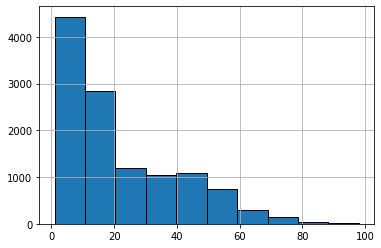

In [20]:
df_ventas_por_pos = df_ventas.groupby('id_pos')[["id_pos"]].count()
df_ventas_por_pos.columns = ["ventas"]
df_ventas_por_pos.ventas.hist(bins=10,edgecolor="k")

Se pueden ver que a a partir de 20 ventas, no es número tan frecuente, podriamos dividir el dataframe en 3 sectores con frecuencia similar:

(0.999, 9.0]    3996
(9.0, 25.0]     3943
(25.0, 98.0]    3914
Name: ventas, dtype: int64


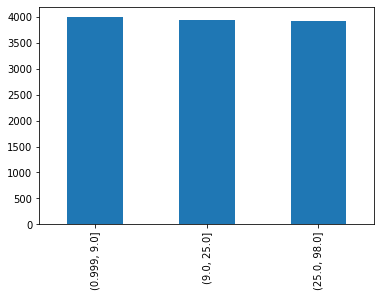

In [21]:
df_ventas_pos_freq = pd.qcut(df_ventas_por_pos.ventas, 3).value_counts()
print(df_ventas_pos_freq)
df_ventas_pos_freq.plot.bar()

Renombramos el indice

In [22]:
df_ventas_pos_freq.index = df_ventas_pos_freq.index.rename_categories(["POCAS", "MEDIO", "MUCHAS"])
df_ventas_pos_freq.index = df_ventas_pos_freq.index.add_categories(['SIN VENTAS'])
df_ventas_pos_freq

POCAS     3996
MEDIO     3943
MUCHAS    3914
Name: ventas, dtype: int64

asignamos a cada categoria, el intervalo al que corresponden: 

In [23]:
df_ventas_pos_freq.index = df_ventas_pos_freq.index.reorder_categories(['SIN VENTAS','POCAS', 'MEDIO', 'MUCHAS'])
df_ventas_pos_freq.index

CategoricalIndex(['POCAS', 'MEDIO', 'MUCHAS'], categories=['SIN VENTAS', 'POCAS', 'MEDIO', 'MUCHAS'], ordered=True, dtype='category')

In [24]:
df_ventas_pos_freq = (
    pd.DataFrame({ 
        "ventas":df_ventas_pos_freq.values, 
        "ini":[1,10,25], 
        "fin":[9,25,98]
    }, index=df_ventas_pos_freq.index)
)

Agregamos el valor 0 para indicar sin ventas

In [25]:
df_ventas_pos_freq = df_ventas_pos_freq.append(pd.DataFrame({"ini":0, "fin":0},index=["SIN VENTAS"]))

In [26]:
df_ventas_pos_freq

fin  ini  ventas
POCAS         9    1  3996.0
MEDIO        25   10  3943.0
MUCHAS       98   25  3914.0
SIN VENTAS    0    0     NaN

Debemos asignarle a cada POS, la cantidad de ventas que posee:

In [27]:
to_merge = df_ventas.groupby('id_pos').size()
to_merge.columns=['cant_ventas']
to_merge.name = "ventas"

df_pos = df_pos.merge(to_merge, on='id_pos', how='left')
# asignamos 0 a las ventas de los POS sin relación con df_venas
df_pos.ventas.fillna(0, inplace=True)
df_pos.tail()

id_pos  competidores  ingreso_mediana  ingreso_promedio  \
12892  124850.0          16.0       63923.2250       85457.13667   
12893  128111.0           2.0       39484.1900       51312.49000   
12894  129492.0          11.0       70850.8225       89329.48250   
12895  129746.0           NaN              NaN               NaN   
12896  131072.0          18.0       68453.5160       91794.14400   

       densidad_poblacional  pct_0a5   pct_5a9  pct_10a14  pct_15a19  \
12892             7727.8950    5.770  5.896667   5.886667   5.438333   
12893              110.7100    6.620  6.410000   9.450000   6.470000   
12894             4735.9825    5.145  6.282500   6.867500   6.470000   
12895                   NaN      NaN       NaN        NaN        NaN   
12896             5935.6400    5.178  5.974000   6.390000   5.828000   

       pct_20a24  pct_25a29  pct_30a34  pct_35a39  pct_40a44  pct_45a49  \
12892   5.751667   6.421667   6.573333   6.211667   6.818333   7.258333   
12893   4.090000   2.740000   5.730000   5.300000   5.410000   3.840000   
12894   6.177500   5.350000   5.590000   6.025000   6.062500   7.117500   
12895        NaN        NaN        NaN        NaN        NaN        NaN   
12896   4.518000   4.514000   5.046000   5.444000   5.952000   6.074000   

       pct_50a54  pct_55a59  pct_60a64  pct_65a69  pct_70a74  pct_75a79  \
12892   7.758333   7.426667   6.571667   5.576667   3.831667   2.603333   
12893   5.690000   6.110000   7.170000   6.470000   3.830000   4.330000   
12894   8.715000   8.507500   6.900000   5.350000   3.722500   2.340000   
12895        NaN        NaN        NaN        NaN        NaN        NaN   
12896   7.692000   8.204000   7.736000   6.508000   4.880000   3.542000   

       pct_80a84  pct_85ainf  pct_bachelors  pct_doctorados  pct_secundario  \
12892      2.110    2.091667        18.7200        2.101667         27.3300   
12893      3.940    6.410000        14.2100        0.210000         31.5400   
12894      1.635    1.745000        21.3175        1.317500         26.6175   
12895        NaN         NaN            NaN             NaN             NaN   
12896      2.930    3.592000        23.8320        1.750000         23.8720   

       pct_master  pct_bicicleta  pct_omnibus  pct_subtes  pct_taxi  \
12892    9.998333       0.693333     1.003333    0.028333  0.121667   
12893    5.020000       0.000000     0.480000    0.000000  0.000000   
12894    6.540000       1.142500     1.707500    0.302500  0.000000   
12895         NaN            NaN          NaN         NaN       NaN   
12896   10.550000       0.140000     0.392000    0.058000  0.048000   

       pct_caminata  mediana_valor_hogar  ventas  
12892         2.120           308094.700     0.0  
12893         4.270            63697.990     0.0  
12894         3.530           494557.765     0.0  
12895           NaN                  NaN     0.0  
12896         1.378           231423.582     0.0

Debemos asignarle la etiqueta a todos los POS que tengan ventas para poder separarlos e imputarlos por grupos:

In [28]:
df_pos["tipo_pos_ventas"] = pd.Series([]).astype(df_ventas_pos_freq.index.dtype)
df_pos = df_pos.set_index('id_pos')

In [29]:
df_pos.sample(5)

competidores  ingreso_mediana  ingreso_promedio  \
id_pos                                                     
10656.0         237.0      55501.29077       71313.77615   
8445.0           38.0      52031.16000       66704.44636   
4621.0            2.0      52186.46500       63311.59500   
6889.0            1.0      55559.71000       64242.54000   
14832.0          26.0      44725.22500       63233.85750   

         densidad_poblacional   pct_0a5   pct_5a9  pct_10a14  pct_15a19  \
id_pos                                                                    
10656.0          15627.956670  6.386923  6.122821   5.962821   6.387692   
8445.0            6042.398182  6.010909  6.154545   5.953636   5.794545   
4621.0             390.185000  6.045000  6.490000   7.710000   6.785000   
6889.0             241.600000  4.690000  4.450000   6.570000   7.380000   
14832.0           9426.987500  4.782500  4.755000   4.597500   5.095000   

         pct_20a24  pct_25a29  pct_30a34  pct_35a39  pct_40a44  pct_45a49  \
id_pos                                                                      
10656.0   9.116154   7.610000   7.156667   5.954359   6.027436   6.052308   
8445.0    7.083636   7.370909   6.979091   6.004545   6.445455   6.459091   
4621.0    5.940000   5.065000   6.095000   6.305000   6.375000   6.150000   
6889.0    7.570000   6.960000   4.470000   4.020000   5.970000   5.790000   
14832.0   9.840000   9.657500   8.075000   6.050000   5.865000   5.805000   

         pct_50a54  pct_55a59  pct_60a64  pct_65a69  pct_70a74  pct_75a79  \
id_pos                                                                      
10656.0   6.677692   6.434359   5.592051   4.626667   3.413077   2.515385   
8445.0    7.287273   6.980909   5.866364   4.597273   3.606364   2.680909   
4621.0    8.995000   6.890000   6.640000   5.055000   2.950000   2.435000   
6889.0    8.160000   9.570000   6.750000   5.400000   5.140000   2.950000   
14832.0   6.357500   6.155000   5.530000   4.777500   3.775000   2.912500   

         pct_80a84  pct_85ainf  pct_bachelors  pct_doctorados  pct_secundario  \
id_pos                                                                          
10656.0   1.889487    2.073590      19.411795        1.708974       27.777692   
8445.0    2.190909    2.533636      16.148182        1.035455       32.008182   
4621.0    1.975000    2.100000      11.435000        0.215000       37.960000   
6889.0    2.350000    1.820000       9.650000        0.250000       40.170000   
14832.0   2.527500    3.437500      19.625000        2.112500       27.287500   

         pct_master  pct_bicicleta  pct_omnibus  pct_subtes  pct_taxi  \
id_pos                                                                  
10656.0    8.587436       0.746667     2.283077    1.758462  0.060256   
8445.0     5.817273       0.454545     1.546364    0.038182  0.055455   
4621.0     4.870000       0.055000     0.715000    0.000000  0.000000   
6889.0     7.470000       0.140000     0.880000    0.280000  0.000000   
14832.0    8.670000       0.452500     1.437500    0.057500  0.282500   

         pct_caminata  mediana_valor_hogar  ventas tipo_pos_ventas  
id_pos                                                              
10656.0      3.617692          203107.2821     6.0             NaN  
8445.0       2.046364          171629.9573    23.0             NaN  
4621.0       2.315000          145728.1700    67.0             NaN  
6889.0       5.750000          196105.0100    25.0             NaN  
14832.0      4.345000          171202.8100    10.0             NaN

Ahora ya podemos imputar por grupo: 

In [30]:
# está funcion se encaga de imputar los valores del dataframe 
# que recibe (todas las columnas por igual)
from src.feature_transformation import impute_values, assign_tipo_pos

In [31]:
assign_tipo_pos(df_pos, df_ventas_pos_freq)
df_pos = df_pos.reset_index('id_pos').groupby('tipo_pos_ventas').apply(impute_values).reset_index(level="tipo_pos_ventas")
df_pos.sample(5)

tipo_pos_ventas   id_pos  competidores  ingreso_mediana  \
2121          MUCHAS   6020.0          54.0      62510.34625   
461       SIN VENTAS  17529.0          22.0      45237.01250   
707            MEDIO   8147.0          28.0      58520.53000   
3392           POCAS  16921.0           6.0      90178.18000   
3288           MEDIO  15228.0           9.0      92161.24500   

      ingreso_promedio  densidad_poblacional   pct_0a5   pct_5a9  pct_10a14  \
2121       80409.77125            17397.1250  6.563750  6.770000   6.575000   
461        56629.94000             8490.5475  5.777500  6.660000   6.530000   
707        80291.21333             6137.0650  5.568333  6.108333   6.191667   
3392      108298.30000            11411.3200  6.780000  6.360000   7.020000   
3288      116914.03500             5700.1450  6.545000  7.155000   6.545000   

      pct_15a19  pct_20a24  pct_25a29  pct_30a34  pct_35a39  pct_40a44  \
2121   8.425000      7.860    7.47375   7.632500    6.72875      6.765   
461    6.172500      6.700    5.68250   6.017500    5.81750      6.395   
707    6.208333      6.295    6.79500   6.458333    6.02000      6.190   
3392   7.030000      6.440    8.18000   8.360000    7.03000      7.190   
3288   6.910000      5.450    4.68500   4.805000    5.53000      6.690   

      pct_45a49  pct_50a54  pct_55a59  pct_60a64  pct_65a69  pct_70a74  \
2121     6.4375   6.695000    6.29625   4.880000   3.555000   2.443750   
461      6.2875   6.610000    6.64250   6.637500   6.557500   4.757500   
707      6.8150   7.311667    7.59500   6.148333   5.028333   4.028333   
3392     7.9900   7.940000    6.50000   4.370000   3.480000   2.260000   
3288     6.6900   7.335000    7.20500   6.250000   5.720000   4.280000   

      pct_75a79  pct_80a84  pct_85ainf  pct_bachelors  pct_doctorados  \
2121   1.833750   1.445000    1.617500      21.488750         1.90625   
461    3.162500   1.915000    1.677500      13.935000         0.49000   
707    2.931667   2.183333    2.118333      20.356667         1.44500   
3392   1.390000   0.840000    0.840000      17.060000         0.46000   
3288   3.415000   2.355000    2.435000      21.160000         3.78000   

      pct_secundario  pct_master  pct_bicicleta  pct_omnibus  pct_subtes  \
2121       21.393750    9.740000           1.16     4.593750    0.503750   
461        32.042500    5.080000           0.26     2.280000    0.015000   
707        26.471667    7.621667           0.18     1.301667    0.418333   
3392       31.400000    7.440000           0.00     0.080000    0.650000   
3288       22.285000   16.050000           0.12     0.440000    2.345000   

      pct_taxi  pct_caminata  mediana_valor_hogar  ventas  
2121   0.08625      4.137500          268355.2238    70.0  
461    0.00000      2.237500          139499.3150     0.0  
707    0.00000      2.796667          254350.1483    16.0  
3392   0.00000      0.320000          281547.5300     8.0  
3288   0.11000      5.390000          458161.4500    10.0

Agregamos la columna tipo_pos_ventas con codificación dummy, quitamos el atributo ventas y tipo_pos_ventas

In [32]:
df_pos = (
    df_pos.set_index('id_pos')
    .merge(pd.get_dummies(df_pos.set_index('id_pos').tipo_pos_ventas), left_index=True, right_index=True)
    .drop(['tipo_pos_ventas'], axis=1, errors='ignore')
    .drop(["ventas"], axis=1, errors='ignore')
)

___

### Análisis correlación
Analizamos la correlación entre las variables, según el tipo. Se pueden identificar grupos de features según sus características, por ejemplo: tenemos porcentajes de edad, porcentaje de estudios, de transporte, de ingresos.
Normalmente, en los modelos de boosting el problema que tenemos con las variables correlacionadas es que reducen el valor de la importancia de las características pero al parecer, no afecta la performance. [Fuente](https://datascience.stackexchange.com/questions/12554/does-xgboost-handle-multicollinearity-by-itself?answertab=votes#tab-top)

Seleccionamos las columnas según al grupo que pertenezcan y generamos: edad, estudios, transporte e ingresos.

In [33]:
from src.cols import cols_edad, cols_estudios, cols_ingresos, cols_transporte

In [34]:
df_pos[cols_edad].describe(include='all')

pct_0a5       pct_5a9     pct_10a14     pct_15a19     pct_20a24  \
count  12897.000000  12897.000000  12897.000000  12897.000000  12897.000000   
mean       6.027519      6.109969      6.053174      6.443285      7.759910   
std        1.240982      1.187279      1.184114      1.851244      3.840706   
min        0.000000      0.000000      0.000000      0.120000      0.270000   
25%        5.410000      5.520000      5.480000      5.655000      6.030000   
50%        5.996250      6.094000      6.060000      6.210000      7.020000   
75%        6.594167      6.694000      6.690000      6.850000      8.310000   
max       21.890000     20.380000     15.280000     41.550000     73.540000   

          pct_25a29     pct_30a34     pct_35a39     pct_40a44     pct_45a49  \
count  12897.000000  12897.000000  12897.000000  12897.000000  12897.000000   
mean       7.176766      6.841664      5.939229      6.283925      6.325110   
std        2.014604      1.450791      0.929227      0.861767      0.910280   
min        0.320000      0.350000      0.340000      0.000000      0.000000   
25%        6.050000      6.075000      5.482500      5.882000      5.906667   
50%        7.020000      6.787500      5.940000      6.310000      6.323750   
75%        7.990000      7.490000      6.392500      6.730000      6.762500   
max       26.740000     18.480000     16.660000     14.980000     13.870000   

          pct_50a54     pct_55a59     pct_60a64     pct_65a69     pct_70a74  \
count  12897.000000  12897.000000  12897.000000  12897.000000  12897.000000   
mean       6.930314      6.691717      5.800446      4.865452      3.627073   
std        1.022446      1.091448      1.187402      1.285254      1.155363   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.476667      6.176000      5.230000      4.220000      3.050000   
50%        6.929412      6.672500      5.720000      4.738333      3.506667   
75%        7.430000      7.210000      6.281667      5.338333      4.027273   
max       14.243333     13.840000     17.360000     20.800000     19.670000   

          pct_75a79     pct_80a84    pct_85ainf  
count  12897.000000  12897.000000  12897.000000  
mean       2.681275      2.090522      2.352090  
std        0.913781      0.788914      1.160933  
min        0.000000      0.000000      0.000000  
25%        2.200000      1.650000      1.690000  
50%        2.596667      2.025000      2.220000  
75%        3.020000      2.401111      2.773137  
max       16.220000     17.300000     25.800000

Verificamos si los porcentajes no dan menores a los valores que se esperan (la suma de todas las columnas debería dar aproximadamente 100%)

In [35]:
df_pos[( df_pos[cols_edad].sum(axis=1) <= 98 )][cols_edad].sum(axis=1)

id_pos
16095.0    97.434134
14224.0    87.017929
dtype: float64

Solamente dos muestra tienen un valor por debajo de 98%, una posee 97% y otra 87%.
Al ser un número tan pequeño, no las imputamos. 

Buscamos cuales son las features de cols_edad que son correlativas entre si, esto nos permite saber que feature se puede calcular a partir de otras.

In [36]:
from src.correlated_columns import print_correlated_columns

Del grupo de columnas "edad" se imprime las columnas que están fuerte y levemente relacionadas de forma lineal.

In [37]:
print_correlated_columns(df_pos, cols_edad, True)

level_0     level_1         0
17     pct_5a9   pct_10a14  0.855512
75   pct_25a29   pct_30a34  0.842661
132  pct_55a59   pct_60a64  0.818492
138  pct_60a64   pct_65a69  0.857084
143  pct_65a69   pct_70a74  0.897539
147  pct_70a74   pct_75a79  0.897684
150  pct_75a79   pct_80a84  0.878132
152  pct_80a84  pct_85ainf  0.855336

In [38]:
print_correlated_columns(df_pos, cols_edad, False, True).sort_values(0, ascending=False)

level_0     level_1         0
0      pct_0a5     pct_5a9  0.792055
144  pct_65a69   pct_75a79  0.791379
125  pct_50a54   pct_55a59  0.788149
117  pct_45a49   pct_50a54  0.758834
148  pct_70a74   pct_80a84  0.745035
139  pct_60a64   pct_70a74  0.744066
87   pct_30a34   pct_35a39  0.743968
108  pct_40a44   pct_45a49  0.727056
151  pct_75a79  pct_85ainf  0.674661
98   pct_35a39   pct_40a44  0.657621
133  pct_55a59   pct_65a69  0.650622
140  pct_60a64   pct_75a79  0.637174
48   pct_15a19   pct_20a24  0.633723
145  pct_65a69   pct_80a84  0.623162
126  pct_50a54   pct_60a64  0.572931
1      pct_0a5   pct_10a14  0.531997
134  pct_55a59   pct_70a74  0.512210
118  pct_45a49   pct_55a59  0.510184
149  pct_70a74  pct_85ainf  0.507128
104  pct_35a39   pct_70a74 -0.501804
105  pct_35a39   pct_75a79 -0.511812
11     pct_0a5   pct_60a64 -0.515317
95   pct_30a34   pct_75a79 -0.516179
12     pct_0a5   pct_65a69 -0.521291
83   pct_25a29   pct_70a74 -0.526114
80   pct_25a29   pct_55a59 -0.526877
81   pct_25a29   pct_60a64 -0.535445
93   pct_30a34   pct_65a69 -0.539826
82   pct_25a29   pct_65a69 -0.544246
94   pct_30a34   pct_70a74 -0.546744
69   pct_20a24   pct_60a64 -0.551058
66   pct_20a24   pct_45a49 -0.584119
68   pct_20a24   pct_55a59 -0.611914
67   pct_20a24   pct_50a54 -0.638862

Las columnas que son fuertemente lineales, tienen valores bastantes altos, y en algunos casos por poco no llegan a 0.8 
Lo que podemos hacer es agrupar estas características, podríamos quitarlos pero trataremos de transformarlos

In [39]:
df_pos.loc[:,'pct_0a14'] = df_pos[cols_edad[0:3]].sum(axis=1)
df_pos.loc[:,'pct_15a39'] = df_pos[cols_edad[3:8]].sum(axis=1)
df_pos.loc[:,'pct_40a59'] = df_pos[cols_edad[8:12]].sum(axis=1)
df_pos.loc[:,'pct_60aInf'] = df_pos[cols_edad[12:]].sum(axis=1)

Realizamos el mismo analisis de correlación lineal: 
    

In [40]:
(
    print_correlated_columns(df_pos, 
                         ['pct_0a14','pct_15a39','pct_40a59','pct_60aInf'], 
                         False, True).sort_values(0, ascending=False)
)

level_0     level_1         0
3  pct_15a39   pct_40a59 -0.674035
4  pct_15a39  pct_60aInf -0.738470

In [41]:
(
    print_correlated_columns(df_pos, 
                         ['pct_0a14','pct_15a39','pct_40a59','pct_60aInf'], 
                         True).sort_values(0, ascending=False)
)

Empty DataFrame
Columns: [level_0, level_1, 0]
Index: []

Con estos cambios, podemos descargar las otras columnas y tenemos 4 nuevas columnas sin perder los datos. 

In [42]:
df_pos.drop(cols_edad, axis=1, inplace=True)

______
Realizamos el mismo analisis para las demás columnas. En este caso las columnas relacionadas al "estudio".

In [43]:
df_pos[cols_estudios].describe(include='all')

pct_secundario  pct_bachelors  pct_doctorados    pct_master
count    12897.000000   12897.000000    12897.000000  12897.000000
mean        28.581207      18.038489        1.310790      7.700283
std          6.760816       6.013396        1.015091      3.434986
min          3.590000       1.950000        0.000000      0.240000
25%         24.690000      14.186000        0.685000      5.422857
50%         28.060000      18.160000        1.140000      7.482500
75%         32.170000      21.380000        1.672500      9.380000
max         57.420000      46.700000       13.900000     30.320000

In [44]:
df_pos.shape, df_pos.loc[:,cols_estudios].sum(axis=1).shape

((12897, 22), (12897,))

Todas las muestras tienen porcentaje faltantes en estudios, asi que vamos a crear una categoría "sin_datos_estudios" para completar el porcentaje faltante (aprovechamos las utilidades de broadcasting de numpy): 

In [45]:
df_pos.loc[:, "sin_datos_estudios"] = 100 - df_pos.loc[:,cols_estudios].sum(axis=1)

Continuamos con el analisis de correlaciones

In [46]:
print_correlated_columns(df_pos, cols_estudios+["sin_datos_estudios"])

pct_secundario  pct_bachelors  pct_doctorados  pct_master  \
pct_secundario            1.000000      -0.818555       -0.634030   -0.774305   
pct_bachelors            -0.818555       1.000000        0.620831    0.857239   
pct_doctorados           -0.634030       0.620831        1.000000    0.755523   
pct_master               -0.774305       0.857239        0.755523    1.000000   
sin_datos_estudios        0.260011      -0.719628       -0.542645   -0.731662   

                    sin_datos_estudios  
pct_secundario                0.260011  
pct_bachelors                -0.719628  
pct_doctorados               -0.542645  
pct_master                   -0.731662  
sin_datos_estudios            1.000000

Podemos agrupar bachelor, master y doctorado como "universitarios":

In [47]:
df_pos.loc[:,"pct_universitarios"] = df_pos.loc[:,cols_estudios[1:]].sum(axis=1)

Volvemos a realizar el análisis de correlación lineal: 

In [48]:
print_correlated_columns(df_pos, ["sin_datos_estudios", "pct_secundario","pct_universitarios"])

sin_datos_estudios  pct_secundario  pct_universitarios
sin_datos_estudios            1.000000        0.260011           -0.749517
pct_secundario                0.260011        1.000000           -0.834099
pct_universitarios           -0.749517       -0.834099            1.000000

Estudios universitarios queda linealmente relacionado con secundario, y no es lo que estamos buscando, intentamos realizar el agrupamiento por "posgrado"

In [49]:
df_pos.drop("pct_universitarios",axis=1, errors='ignore', inplace=True)
df_pos.loc[:, "pct_posgrado"] = df_pos.loc[:,cols_estudios[2:]].sum(axis=1)

In [50]:
print_correlated_columns(df_pos, ["sin_datos_estudios", "pct_secundario","pct_bachelors", "pct_posgrado"])

sin_datos_estudios  pct_secundario  pct_bachelors  \
sin_datos_estudios            1.000000        0.260011      -0.719628   
pct_secundario                0.260011        1.000000      -0.818555   
pct_bachelors                -0.719628       -0.818555       1.000000   
pct_posgrado                 -0.720247       -0.776484       0.840298   

                    pct_posgrado  
sin_datos_estudios     -0.720247  
pct_secundario         -0.776484  
pct_bachelors           0.840298  
pct_posgrado            1.000000

Podemos observar que pct_bachelors se comporta linealmente casi con todas las demás características, procedemos a eliminarla

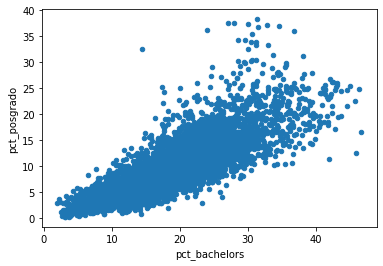

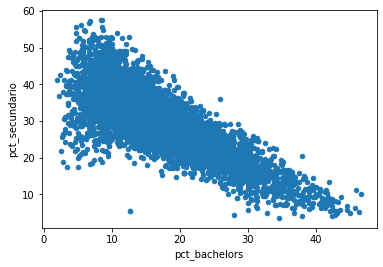

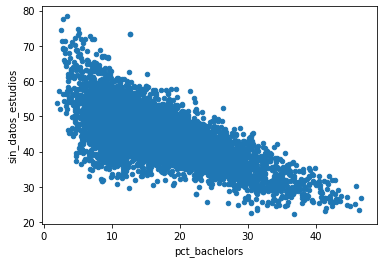

In [51]:
df_pos.plot.scatter(x='pct_bachelors', y='pct_posgrado')
df_pos.plot.scatter(x='pct_bachelors', y='pct_secundario')
df_pos.plot.scatter(x='pct_bachelors', y='sin_datos_estudios')

In [52]:
df_pos.drop(["pct_bachelors", "pct_doctorados", "pct_master"],axis=1, inplace=True, errors='ignore')

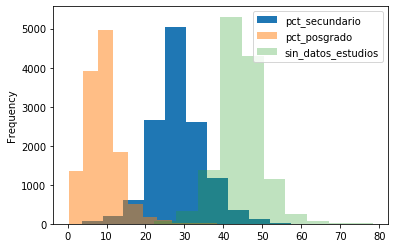

In [53]:
df_pos.pct_secundario.plot.hist()
df_pos.pct_posgrado.plot.hist(alpha=0.5)
df_pos.sin_datos_estudios.plot.hist(alpha=0.3)
plt.legend()

Parece que las columnas "secundario" y "universitarios" están relacionadas casi linealmente, como nuestras variables deben ser independientes quizás debamos remover una de ellas. 

____
Nuevamente, realizamos el mismo analisis para el grupo de columnas de "ingresos"

In [54]:
df_pos[cols_ingresos].describe(include='all')

ingreso_mediana  ingreso_promedio  mediana_valor_hogar
count     12897.000000      12897.000000         1.289700e+04
mean      55230.557359      72561.925000         2.177605e+05
std       14892.400657      18963.264759         1.210775e+05
min       15519.520000      22629.590000         0.000000e+00
25%       45787.240000      60224.701430         1.441982e+05
50%       54041.010000      70778.705000         1.966274e+05
75%       62078.196250      81275.626550         2.570590e+05
max      165644.920000     201504.010000         1.710129e+06

In [55]:
print_correlated_columns(df_pos, cols_ingresos, True)

level_0           level_1         0
0  ingreso_mediana  ingreso_promedio  0.978482

In [56]:
print_correlated_columns(df_pos, cols_ingresos, False, True)

level_0              level_1         0
0  ingreso_promedio  mediana_valor_hogar  0.773522
1   ingreso_mediana  mediana_valor_hogar  0.712455

Podemos observar que la media y la mediana están relacionadas linealmente, asi que podemos descargar una de ellas. Verificamos en un gráfico:  

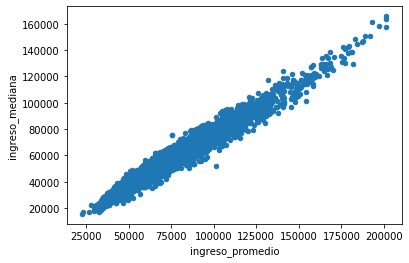

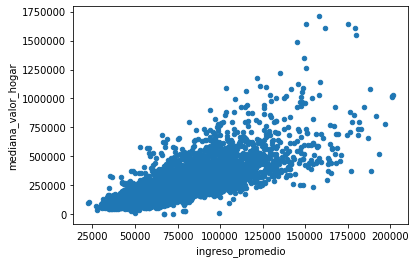

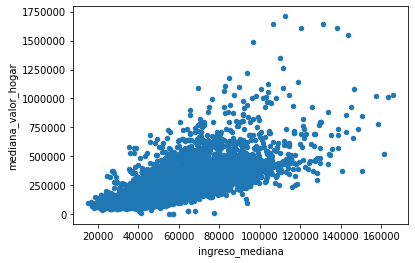

In [57]:
df_pos[cols_ingresos].plot.scatter(x='ingreso_promedio', y='ingreso_mediana')
df_pos[cols_ingresos].plot.scatter(x='ingreso_promedio', y='mediana_valor_hogar')
df_pos[cols_ingresos].plot.scatter(x='ingreso_mediana', y='mediana_valor_hogar')

Removemos ingresos_promedios de las columnas [¿mejor eliminar una con mayor std/var, o la que es menos lineal?]

In [58]:
df_pos.drop('ingreso_promedio', axis=1, inplace=True)

___
Realizamos el mismo analisis para las columnas del transporte

In [59]:
df_pos[cols_transporte].describe(include='all')

pct_bicicleta   pct_omnibus    pct_subtes      pct_taxi  pct_caminata
count   12897.000000  12897.000000  12897.000000  12897.000000  12897.000000
mean        0.616114      2.240992      1.437914      0.140254      3.627518
std         0.823949      2.696924      5.174640      0.333907      3.927686
min         0.000000      0.000000      0.000000      0.000000      0.000000
25%         0.160000      0.636667      0.000000      0.000000      1.621667
50%         0.416000      1.580000      0.072857      0.046667      2.581429
75%         0.767500      2.850000      0.556000      0.140000      4.160000
max        17.890000     35.970000     72.970000      6.490000     80.960000

In [60]:
df_pos.shape, (df_pos[cols_transporte].sum(axis=1) < 100).shape

((12897, 20), (12897,))

In [61]:
print_correlated_columns(df_pos, cols_transporte)

pct_bicicleta  pct_omnibus  pct_subtes  pct_taxi  pct_caminata
pct_bicicleta       1.000000     0.289827    0.122577  0.103947      0.383638
pct_omnibus         0.289827     1.000000    0.319274  0.215362      0.332458
pct_subtes          0.122577     0.319274    1.000000  0.510634      0.341301
pct_taxi            0.103947     0.215362    0.510634  1.000000      0.425348
pct_caminata        0.383638     0.332458    0.341301  0.425348      1.000000

Se puede observar que no hay relación lineal entre estas columnas y también que todos los datos no tienen el 100% de las respuestas. Agregamos una columna de "transporte_sin_datos". Seguramente estos datos no serán tenidos en cuenta a la hora de entrenar al modelo dado que la mayoría de los datos están faltantes, eso se puede ver en el siguiente histograma, donde la mayoría de los datos de "transporte_sin_datos" se encuentra entre el 80 y 100% de los datos.

In [62]:
df_pos["transporte_sin_datos"] = 100 - df_pos[cols_transporte].sum(axis=1)

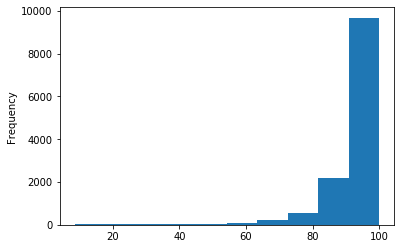

In [63]:
df_pos["transporte_sin_datos"].plot.hist()

___

De las columnas resultantes, solo densidad poblacional está linealmente relacionada con pct_subtes, y está relacionada tambien linealmente leve con varios de los transportes. Como se dijo en el apartado anterior, no se retira la columna porque seguramente a la hora de entrenar el modelo la vamos a retirar.

In [64]:
print_correlated_columns(df_pos, df_pos.columns, True)

level_0     level_1         0
42  densidad_poblacional  pct_subtes  0.853092

In [65]:
print_correlated_columns(df_pos, df_pos.columns, False, True)

level_0               level_1         0
21        ingreso_mediana        pct_secundario -0.549854
27        ingreso_mediana   mediana_valor_hogar  0.712455
36        ingreso_mediana    sin_datos_estudios -0.611029
37        ingreso_mediana          pct_posgrado  0.675399
41   densidad_poblacional           pct_omnibus  0.501230
43   densidad_poblacional              pct_taxi  0.611526
62         pct_secundario   mediana_valor_hogar -0.619266
72         pct_secundario          pct_posgrado -0.776484
104           pct_omnibus  transporte_sin_datos -0.635075
105            pct_subtes              pct_taxi  0.510634
131              pct_taxi  transporte_sin_datos -0.565643
138          pct_caminata             pct_15a39  0.548783
143          pct_caminata  transporte_sin_datos -0.750366
153   mediana_valor_hogar          pct_posgrado  0.673211
195             pct_15a39             pct_40a59 -0.674035
196             pct_15a39            pct_60aInf -0.738470
207    sin_datos_estudios          pct_posgrado -0.720247

Guardamos el modelo para el entrenamiento.

In [66]:
df_pos.to_parquet('data/01-pos.parquet')

________

kmeans para los pos
silhoeutte: 
    The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
davies bouldin: 
    Zero is the lowest possible score. Values closer to zero indicate a better partition.

In [67]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

X = df_pos.dropna(axis=0)
X = X.join(pd.get_dummies(X.tipo_pos_ventas)).drop(['tipo_pos_ventas', 'ventas'], axis=1, errors='ignore')
X = MinMaxScaler().fit_transform(X)

df = pd.DataFrame(columns=["K","silhoeutte", "davies"])

for i in range(2,20):
    # clustering = DBSCAN(eps=0.2, min_samples=2).fit(X)
    kmeans = KMeans(n_clusters=i, random_state=1).fit(X)
    labels = kmeans.labels_
    df = df.append([pd.Series({"K":i, 
               "silhoeutte": metrics.silhouette_score(X, labels, metric='euclidean'), 
               "davies": metrics.davies_bouldin_score(X, labels)
              })], ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'tipo_pos_ventas'

In [ ]:
df[["silhoeutte", "davies"]].plot.line(subplots=True,figsize=(12,10))